# Capstone 3 - Pre-processing and modeling

Can we predict the electricity load for three cities of Panama, considering meteorologic conditions, holidays, and school schedule?

In [1]:
# Modules importation
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

C:\Users\laurence\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Importing the dataset
data = pd.read_csv(r'C:\Users\laurence\OneDrive\Data Science\Capstone 3\capstone3_data_EDA.csv')
data.datetime = pd.to_datetime(data.datetime)
data = data.set_index("datetime")

In [3]:
# Droping the 2020 data, affected by the global pandemic.
data = data[(data['year'] != 2020)]

In [4]:
# Resampling on a weekly basis
data_uni_w = data['nat_elec_load'].resample("W").sum()
data_uni_w.drop(data_uni_w.tail(1).index,inplace=True)
data_uni_w.drop(data_uni_w.head(1).index,inplace=True)
data_uni_w = pd.DataFrame(data_uni_w)

In [5]:
# Visualization of end of the dataset to see the last entries
print(data_uni_w.head(3))
print(data_uni_w.tail(3))

            nat_elec_load
datetime                 
2015-01-11    181919.6224
2015-01-18    188082.3152
2015-01-25    179448.7184
            nat_elec_load
datetime                 
2019-12-15    220102.1454
2019-12-22    225592.3476
2019-12-29    206109.1895


<AxesSubplot:xlabel='datetime'>

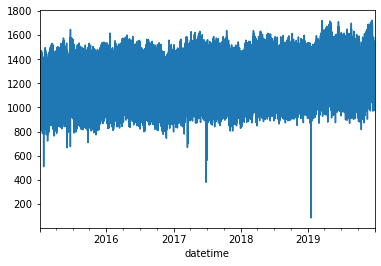

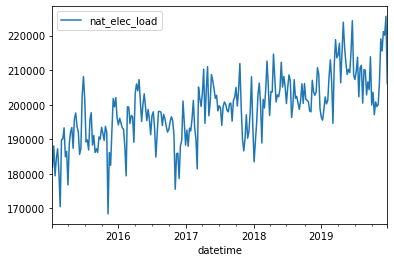

In [6]:
# Visualization of the original and the resampled data on a weekly basis.
data['nat_elec_load'].plot()
data_uni_w.plot()

<AxesSubplot:xlabel='datetime'>

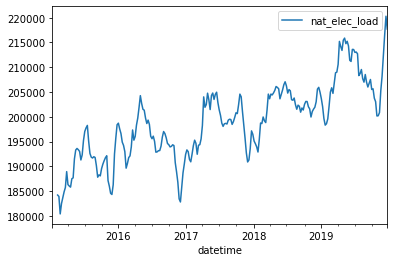

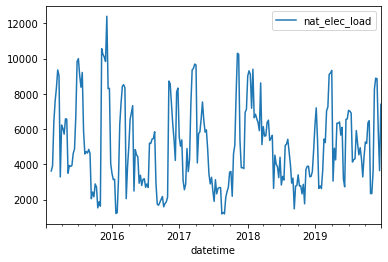

In [7]:
# Verification of the stationarity of the nat_elec_load feature
rolling_mean = data_uni_w.rolling(window = 5).mean()
rolling_std = data_uni_w.rolling(window = 5).std()

rolling_mean.plot()
rolling_std.plot()

The rolling standard deviation is flat, while there is an increase in the rolling mean.

In [8]:
# Augmented Dickey-Fuller test to verify stationarity
adfuller(data_uni_w)

(-2.3280140475257887,
 0.16309197981763768,
 5,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 4926.952670738553)

The p value is over 0.05. The null hypothesis is not rejected, indicating that the data is considered as not stationary.

In [9]:
# Augmented Dickey-Fuller test to verify stationarity with one differenciation.
diff = data_uni_w["nat_elec_load"].diff().dropna()
adfuller(diff)

(-12.182456448733658,
 1.3418641029022345e-22,
 4,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 4909.081673892859)

The p value is now below 0.05. The null hypothesis is then rejected, indicating that the data is now considered as stationary when there is one differenciation. The d parameter will hence have to be set to 1.

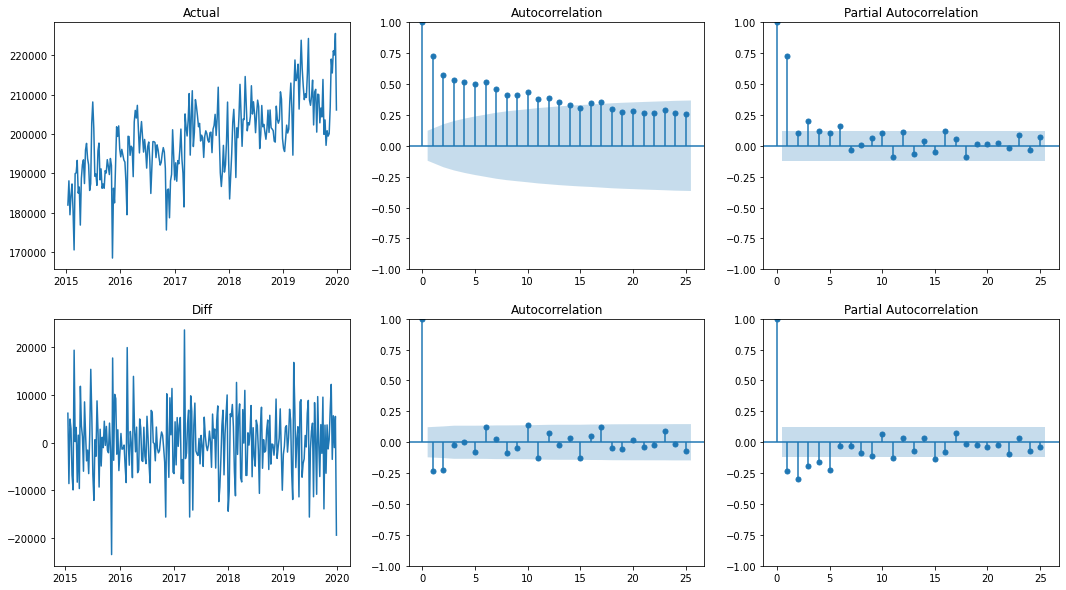

In [10]:
# Verification of the autocorrelation function and pqrtial autocorrelation function
fig, axes = plt.subplots(2, 3, figsize = (18,10))
axes[0,0].plot(data_uni_w); axes[0,0].set_title('Actual')
plot_acf(data_uni_w, ax=axes[0,1])
plot_pacf(data_uni_w, ax=axes[0,2])
axes[1,0].plot(data_uni_w.diff()); axes[1,0].set_title('Diff')
plot_acf(data_uni_w.diff().dropna(), ax=axes[1,1])
plot_pacf(data_uni_w.diff().dropna(), ax=axes[1,2])
plt.show()

In [11]:
# Train test split - test dataset corresponding to the 2019 year.
train_uni = data_uni_w[:207] 
test_uni = data_uni_w[207:]

data2019 = data_uni_w['nat_elec_load'][207:]

In [12]:
# Defining a data frame that will host all the results
results = pd.DataFrame()

In [13]:
# Definition of a function to obtain metrics
def fc_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**0.5    
    return({'mape': mape, 'me': me, 'mae': mae, 'mpe': mpe, 'rmse': rmse})

## Univariate ARIMA model (manual implementation) 

In [14]:
# Initiating the model
arima_manual = sm.tsa.statespace.SARIMAX(train_uni, order = (1,1,1), seasonal_order = (0,1,1,52)).fit()

In [15]:
# Making prediction for 2019
future_forecast_arima_manual = arima_manual.get_forecast(steps = 53)
results['future_forecast_arima_manual'] = pd.DataFrame(future_forecast_arima_manual.predicted_mean)

<AxesSubplot:>

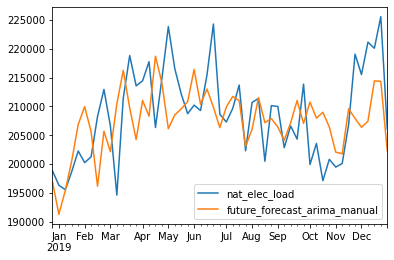

In [16]:
# Visualisation of the transformed real and predicted data
pd.concat([test_uni, results['future_forecast_arima_manual']], axis = 1).plot()

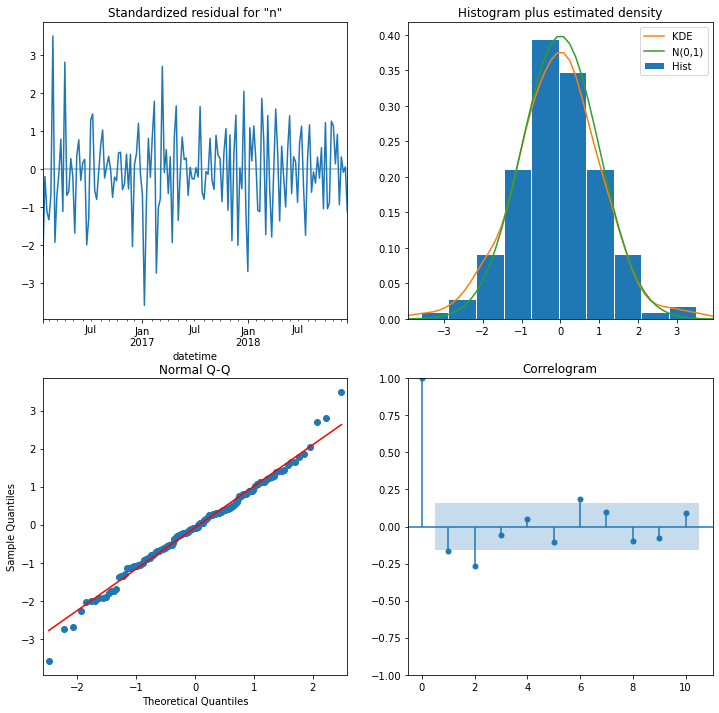

In [17]:
# Visualisation of the model diagnostic
arima_manual.plot_diagnostics(figsize=(12,12))
plt.show()

In [18]:
arima_manual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      nat_elec_load   No. Observations:                  207
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -1607.899
Date:                            Fri, 03 Mar 2023   AIC                           3223.798
Time:                                    14:26:01   BIC                           3235.946
Sample:                                01-11-2015   HQIC                          3228.732
                                     - 12-23-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5395      0.192      2.806      0.005       0.163       0.916
ma.L1         -0.6146      0.185     -3.316      0.001      -0.978      -0.251
ma.S.L52      -0.2093      0.018    -11.938      0.000      -0.244      -0.175
sigma2      5.664e+07    5.3e-09   1.07e+16      0.000    5.66e+07    5.66e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.23   Jarque-Bera (JB):                 4.25
Prob(Q):                              0.04   Prob(JB):                         0.12
Heteroskedasticity (H):               0.87   Skew:                            -0.02
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+31. Standard errors may be unstable.
"""

In [19]:
# Printing the Akaike information criterion 
aic_arima_manual = 3223.798
aic_arima_manual

3223.798

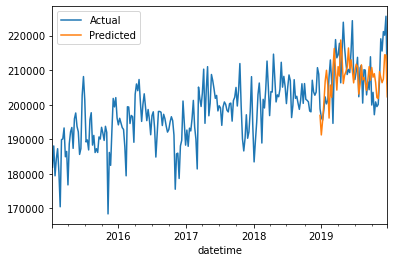

In [20]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['future_forecast_arima_manual'].plot(label = 'Predicted')
plt.legend()

In [21]:
acc_manual = fc_accuracy( results['future_forecast_arima_manual'], data2019)
acc_manual

{'mape': 0.02773971299079501,
 'me': -1163.242320916879,
 'mae': 5830.724553975619,
 'mpe': -0.004614531955249988,
 'rmse': 7305.935325105433}

## Univariate ARIMA model (auto-arima)

In [22]:
# Parameter tuning using stepwise_model
stepwise_model_uni = auto_arima(train_uni, start_p = 0, d = 1, start_q = 0, max_p = 10, max_d = 5, max_q = 5, start_P = 0,
                                D = 1, start_Q = 0, m = 52, seasonal = True, error_action = 'ignore', trace = True, 
                                suppress_warnings = True, stepwise = True, random_state = 20, n_fits = 50, test = 'adf')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3234.269, Time=1.00 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3224.827, Time=2.94 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=3222.722, Time=4.08 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=3237.620, Time=0.61 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=13.29 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=14.41 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=3225.426, Time=3.73 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=34.97 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=3221.764, Time=6.24 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=7.20 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=3218.583, Time=11.19 sec
 ARIMA(0,1,0)(1,1,2)[52]             : AIC=inf, Time=23.05 sec
 ARIMA(1,1,0)(0,1,2)[52]             : AIC=3219.088, Time=13.04 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=inf, Time=26.16 sec
 ARIMA(0,1,0)(0,1,2)[52] intercept   : AIC

In [23]:
# Printing the Akaike information criterion 
aic_uni = stepwise_model_uni.aic()
aic_uni

3218.582881215462

In [24]:
# Training data using the tuned model
stepwise_model_uni.fit(train_uni)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 2, 52),
      suppress_warnings=True, with_intercept=False)

In [25]:
# Making prediction for 2019
future_forecast_uni = stepwise_model_uni.predict(n_periods = 53)

results = pd.DataFrame()
results['future_forecast_uni'] = pd.DataFrame(future_forecast_uni, index = test_uni.index, columns = ['Prediction_uni'])

<AxesSubplot:xlabel='datetime'>

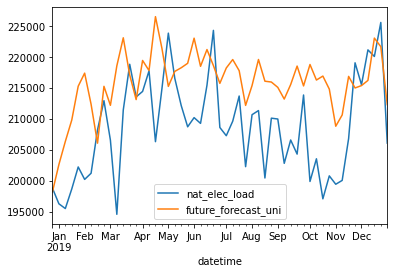

In [26]:
# Visualisation of the transformed real and predicted data
pd.concat([test_uni, results['future_forecast_uni']], axis = 1).plot()

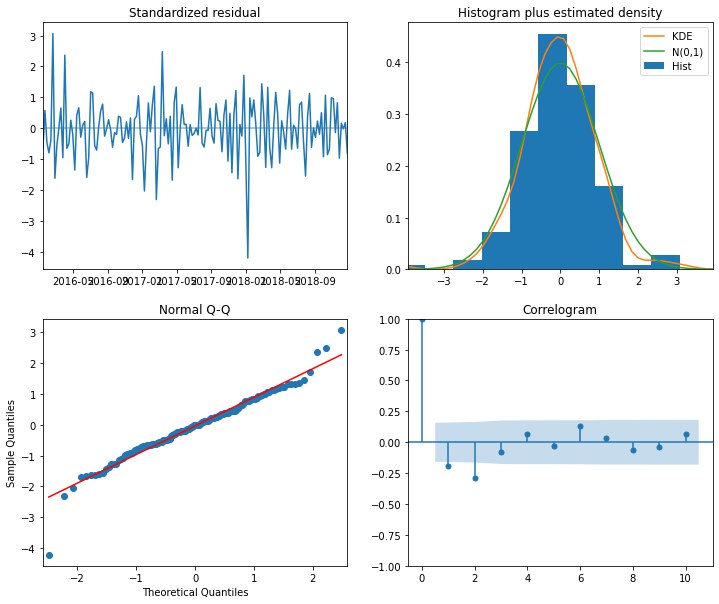

In [27]:
# Visualisation of the model diagnostic
stepwise_model_uni.plot_diagnostics(figsize=(12,10))
plt.show()

In [28]:
# Printing the model summary
print(stepwise_model_uni.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  207
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 52)   Log Likelihood               -1606.291
Date:                                 Fri, 03 Mar 2023   AIC                           3218.583
Time:                                         14:29:39   BIC                           3227.694
Sample:                                     01-11-2015   HQIC                          3222.284
                                          - 12-23-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -0.3389      0.041     -8.276      0.000      -0.419      -0

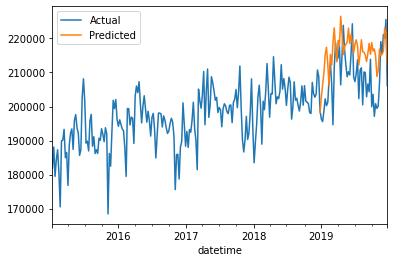

In [29]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['future_forecast_uni'].plot(label = 'Predicted')
plt.legend()

In [30]:
data2019 = data_uni_w['nat_elec_load'][207:]

acc_uni = fc_accuracy( results['future_forecast_uni'], data2019)
acc_uni

{'mape': 0.0407914233085985,
 'me': 7154.478479496484,
 'mae': 8369.995477978535,
 'mpe': 0.03529300024877016,
 'rmse': 10014.424987194732}

## Multivariate Arima model considering exogenous variables (auto-arima)

In [31]:
# Resampling on a weekly basis with the sum or the mean, depending on the feature
data_multi = pd.DataFrame()
data_multi['nat_elec_load'] = data['nat_elec_load'].resample("W").sum()
data_multi['t_toc'] = data['t_toc'].resample("W").mean()
data_multi['h_toc'] = data['h_toc'].resample("W").mean()
data_multi['p_toc'] = data['p_toc'].resample("W").sum()
data_multi['ws_toc'] = data['ws_toc'].resample("W").mean()
data_multi['t_san'] = data['t_san'].resample("W").mean()
data_multi['h_san'] = data['h_san'].resample("W").mean()
data_multi['p_san'] = data['p_san'].resample("W").sum()
data_multi['ws_san'] = data['ws_san'].resample("W").mean()
data_multi['t_dav'] = data['t_dav'].resample("W").mean()
data_multi['h_dav'] = data['h_dav'].resample("W").mean()
data_multi['p_dav'] = data['p_dav'].resample("W").sum()
data_multi['ws_dav'] = data['ws_dav'].resample("W").mean()
data_multi['holiday_ID'] = data['holiday_ID'].resample("W").sum()
data_multi['holiday'] = data['holiday'].resample("W").sum()
data_multi['school'] = data['school'].resample("W").sum()

data_multi.drop(data_multi.tail(1).index,inplace=True)
data_multi.drop(data_multi.head(1).index,inplace=True)
data_multi = pd.DataFrame(data_multi)

data_multi.head()

,nat_elec_load,t_toc,h_toc,p_toc,ws_toc,t_san,h_san,p_san,ws_san,t_dav,h_dav,p_dav,ws_dav,holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-11,181919.6224,26.829882,0.017483,3.443329,25.429599,25.733156,0.016941,3.995602,13.844652,23.820581,0.015845,17.169937,6.687586,48.0,24.0,0.0
2015-01-18,188082.3152,27.047046,0.017778,7.872233,20.616549,26.108616,0.017291,11.167252,8.728468,24.394144,0.016080,20.262146,3.462595,0.0,0.0,0.0
2015-01-25,179448.7184,26.586434,0.016808,13.071503,18.210324,25.853082,0.016226,13.993546,8.015694,23.845967,0.015266,19.622757,3.004145,0.0,0.0,0.0
2015-02-01,184393.4256,27.024779,0.016309,5.475823,24.159216,26.246552,0.015350,6.404824,12.579642,23.686981,0.014966,15.239387,5.659424,0.0,0.0,0.0
2015-02-08,187290.1846,27.346896,0.017026,5.995931,20.208824,27.558020,0.016060,10.450697,9.342399,24.438553,0.015646,18.350250,3.755133,0.0,0.0,0.0


In [32]:
# Definition of a function to obtain the Dickey-Fuller test results for all features of the dataset.
def adfuller_test(series, signif=0.05):
    x = adfuller(series, autolag='AIC')
    output = {'Test Statistic': x[0], 
              'P-value': x[1], 
              'Number of lags': x[2], 
              'Number of observations': x[3],
              f'Reject (signif. level {signif})': x[1] < signif }
    for key, val in x[4].items():
         output[f'Critical value {key}'] = val
    return pd.Series(output)

In [33]:
data_multi.apply(lambda x: adfuller_test(x), axis=0)

,nat_elec_load,t_toc,h_toc,p_toc,ws_toc,t_san,h_san,p_san,ws_san,t_dav,h_dav,p_dav,ws_dav,holiday_ID,holiday,school
Test Statistic,-2.328014,-4.147768,-4.920268,-3.77971,-4.615757,-4.209354,-5.190418,-4.848723,-4.397102,-4.349681,-5.064249,-4.004139,-5.41961,-3.754414,-4.207352,-3.958252
P-value,0.163092,0.000807,0.000032,0.003122,0.000121,0.000635,0.000009,0.000044,0.0003,0.000364,0.000017,0.001389,0.000003,0.00341,0.00064,0.001646
Number of lags,5,2,9,2,8,0,7,8,2,0,7,2,2,6,6,16
Number of observations,254,257,250,257,251,259,252,251,257,259,252,257,257,253,253,243
Reject (signif. level 0.05),False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Critical value 1%,-3.45636,-3.456054,-3.456781,-3.456054,-3.456674,-3.455853,-3.456569,-3.456674,-3.456054,-3.455853,-3.456569,-3.456054,-3.456054,-3.456464,-3.456464,-3.457551
Critical value 5%,-2.872987,-2.872853,-2.873172,-2.872853,-2.873125,-2.872765,-2.873079,-2.873125,-2.872853,-2.872765,-2.873079,-2.872853,-2.872853,-2.873033,-2.873033,-2.873509
Critical value 10%,-2.57287,-2.572799,-2.572969,-2.572799,-2.572944,-2.572752,-2.572919,-2.572944,-2.572799,-2.572752,-2.572919,-2.572799,-2.572799,-2.572895,-2.572895,-2.573148


As seen before, nat_elec_load is not stationary, but it is the only one non-stationary feature of the dataset. We already know that one degree differenciation is enough to transform the data into stationary.

In [34]:
# Train test split - test dataset corresponding to the 2019 year.
train = data_multi["nat_elec_load"][1:207] 
test = data_multi["nat_elec_load"][207:]

exo_train = data_multi.drop("nat_elec_load", axis = 1)[1:207]
exo_test = data_multi.drop("nat_elec_load", axis = 1)[207:]

In [35]:
stepwise_model_multi_exo = auto_arima(train, exogenous = exo_train, start_p = 0, d = 1, start_q = 0, max_p = 10, max_d = 5,
                                      max_q = 5, start_P = 0, D = 1, start_Q = 0, m = 52, seasonal = True,
                                      error_action = 'ignore', trace = True, suppress_warnings = True, stepwise = True,
                                      random_state = 20, n_fits = 50, test = 'adf')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3213.536, Time=1.26 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3203.856, Time=3.33 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=3198.967, Time=4.63 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=3210.782, Time=0.70 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=10.30 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=13.51 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=3203.813, Time=3.25 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=26.76 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=3203.222, Time=6.13 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=3201.522, Time=7.02 sec
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=3206.785, Time=5.71 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=3199.589, Time=4.05 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=3208.780, Time=14.88 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=3201.021, Time=5.77 sec

Best model:  ARIMA(0,1,1)(0,1

In [36]:
# Printing the Akaike information criterion 
aic_multi_exo = stepwise_model_multi_exo.aic()
aic_multi_exo

3198.9667241892353

In [37]:
# Training data using the model
stepwise_model_multi_exo.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 52),
      suppress_warnings=True, with_intercept=False)

In [38]:
# Making prediction for 2019
future_forecast_multi_exo = stepwise_model_multi_exo.predict(n_periods = 53, exogenous = exo_train)
results['future_forecast_multi_exo'] = pd.DataFrame(future_forecast_multi_exo, index = test_uni.index, columns = ['Prediction_multi_exo'])

<AxesSubplot:xlabel='datetime'>

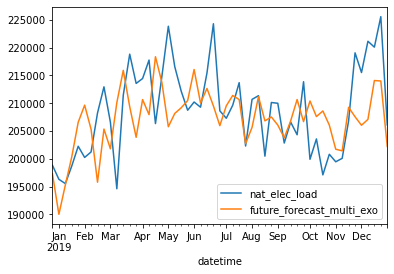

In [39]:
# Visualisation of the transformed real and predicted data
pd.concat([test, results['future_forecast_multi_exo']], axis = 1).plot()

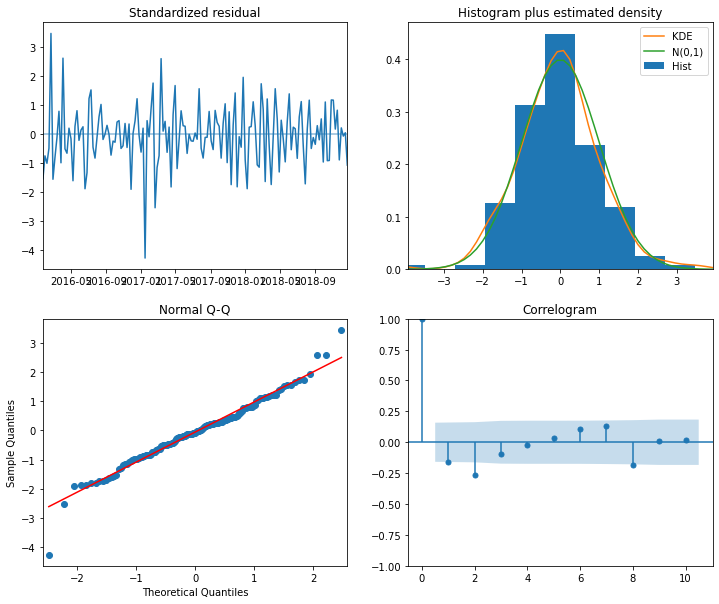

In [40]:
# Visualisation of the model diagnostic
stepwise_model_multi_exo.plot_diagnostics(figsize=(12,10))
plt.show()

In [41]:
# Printing the model summary
print(stepwise_model_multi_exo.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  206
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -1596.483
Date:                            Fri, 03 Mar 2023   AIC                           3198.967
Time:                                    14:31:36   BIC                           3208.058
Sample:                                01-18-2015   HQIC                          3202.660
                                     - 12-23-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1198      0.031     -3.809      0.000      -0.181      -0.058
ma.S.L52      -0.2074      0.016   

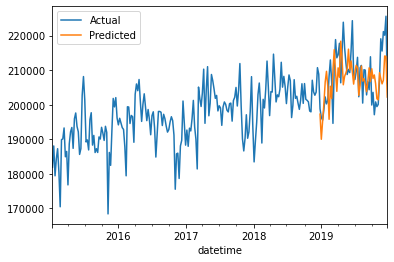

In [42]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['future_forecast_multi_exo'].plot(label = 'Predicted')
plt.legend()

In [43]:
acc_multi_exo = fc_accuracy(results['future_forecast_multi_exo'], data2019)
acc_multi_exo

{'mape': 0.027833622230037585,
 'me': -1503.9462237344442,
 'mae': 5857.722510154012,
 'mpe': -0.006249037677414386,
 'rmse': 7379.808098826168}

## Multivariate Arima model (seasonal_index as the exogenous feature) (auto-arima)

In [44]:
# Obtaining the seasonal index
seasonal_dec = seasonal_decompose(x=data_uni_w['nat_elec_load'], model = 'additive', extrapolate_trend='freq')
seasonal_index = seasonal_dec.seasonal[207:].to_frame()

In [45]:
stepwise_model_multi_si = auto_arima(train, exogenous = seasonal_index, start_p = 0, d = 1, start_q = 0, max_p = 10,
                                     max_d = 5, max_q = 5, start_P = 0, D = 1, start_Q = 0, m = 52, seasonal = True, 
                                     error_action = 'ignore', trace = True, suppress_warnings = True, stepwise = True, 
                                     random_state = 20, n_fits = 50, test = 'adf')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3213.536, Time=1.29 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3203.856, Time=3.69 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=3198.967, Time=3.81 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=3210.782, Time=0.57 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=11.81 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=13.74 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=3203.813, Time=3.35 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=25.98 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=3203.222, Time=5.74 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=3201.522, Time=7.11 sec
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=3206.785, Time=5.71 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=3199.589, Time=3.84 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=3208.780, Time=15.51 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=3201.021, Time=4.04 sec

Best model:  ARIMA(0,1,1)(0,1

In [46]:
# Printing the Akaike information criterion 
aic_multi_si = stepwise_model_multi_si.aic()
aic_multi_si

3198.9667241892353

In [47]:
# Training data using the model
stepwise_model_multi_si.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 52),
      suppress_warnings=True, with_intercept=False)

In [48]:
# Making prediction for 2019
future_forecast_multi_si = stepwise_model_multi_si.predict(n_periods = 53, exogenous = seasonal_index)
results['future_forecast_multi_si'] = pd.DataFrame(future_forecast_multi_exo, index = test_uni.index, columns = ['Prediction_multi_exo'])

<AxesSubplot:>

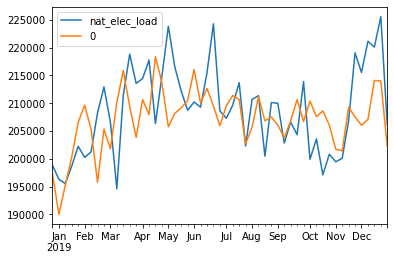

In [49]:
# Visualisation of the transformed real and predicted data
pd.concat([test, future_forecast_multi_si], axis = 1).plot()

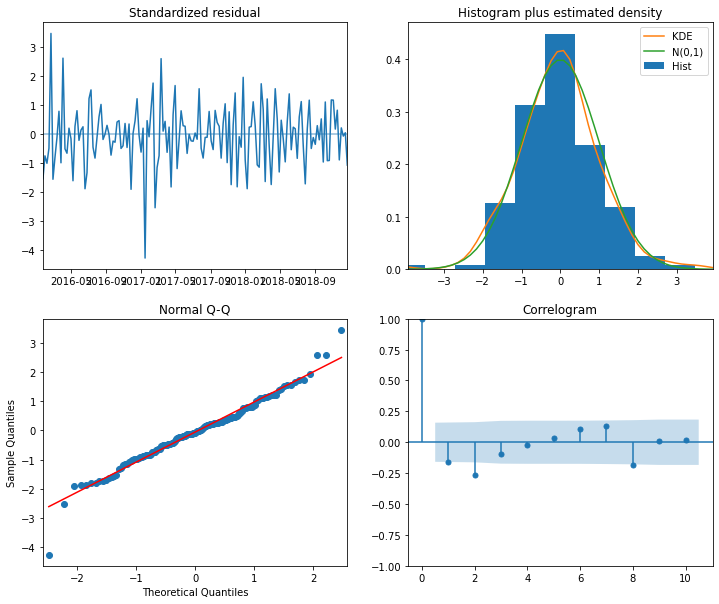

In [50]:
# Visualisation of the model diagnostic
stepwise_model_multi_si.plot_diagnostics(figsize=(12,10))
plt.show()

In [51]:
# Printing the model summary
print(stepwise_model_multi_si.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  206
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -1596.483
Date:                            Fri, 03 Mar 2023   AIC                           3198.967
Time:                                    14:33:30   BIC                           3208.058
Sample:                                01-18-2015   HQIC                          3202.660
                                     - 12-23-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1198      0.031     -3.809      0.000      -0.181      -0.058
ma.S.L52      -0.2074      0.016   

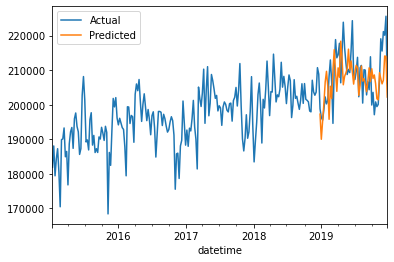

In [52]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['future_forecast_multi_si'].plot(label = 'Predicted')
plt.legend()

In [53]:
acc_multi_si = fc_accuracy(results['future_forecast_multi_si'], data2019)
acc_multi_si

{'mape': 0.027833622230037585,
 'me': -1503.9462237344442,
 'mae': 5857.722510154012,
 'mpe': -0.006249037677414386,
 'rmse': 7379.808098826168}

## VAR model

In [54]:
# Initiating the VAR model using all available data and the differentiated target data
var_model = VAR(data_multi)

In [55]:
# Selecting the appropriate lag of the model
order = var_model.select_order()
order.summary()

,AIC,BIC,FPE,HQIC
0,-3.808,-3.580,0.02219,-3.716
1,-10.16,-6.289*,3.863e-05,-8.604
2,-10.05,-2.523,4.447e-05,-7.017
3,-9.776,1.396,6.194e-05,-5.277
4,-9.273,5.546,0.0001153,-3.306
5,-9.181,9.286,0.0001548,-1.745
6,-9.248,12.87,0.0001984,-0.3434
7,-9.283,16.48,0.0003051,1.090
8,-9.576,19.83,0.0004435,2.266
9,-9.641,23.42,0.001064,3.670


14 lags, showing the most minimum values, was selected for modeling.

In [56]:
# Fiting the model using 14 lags
var_results = var_model.fit(14)
var_results.summary()
lag_order = var_results.k_ar

In [57]:
# Making prediction for 2019
future_forecast_var = var_results.forecast(data_multi.values[-lag_order:], 53)
future_forecast_var = pd.DataFrame(future_forecast_var)
future_forecast_var.columns = ['nat_elec_load','t_toc', 'h_toc', 'p_toc', 'ws_toc', 't_san', 'h_san', 'p_san', 'ws_san', 't_dav', 'h_dav',
                            'p_dav', 'ws_dav', 'holiday_ID', 'holiday', 'school']
prediction_var = future_forecast_var['nat_elec_load']

In [58]:
date = ['2018-12-30', '2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27', '2019-02-03', '2019-02-10', '2019-02-17',
        '2019-02-24', '2019-03-03', '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
        '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-12', '2019-05-19', '2019-05-26', '2019-06-02', '2019-06-09',
        '2019-06-16', '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04',
        '2019-08-11', '2019-08-18', '2019-08-25', '2019-09-01', '2019-09-08', '2019-09-15', '2019-09-22', '2019-09-29',
        '2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
        '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22', '2019-12-29']
date = pd.DataFrame(date, columns = ['datetime'])

In [59]:
prediction_var = pd.concat([date, prediction_var], axis = 1)
prediction_var.datetime = pd.to_datetime(prediction_var.datetime)
prediction_var = prediction_var.set_index("datetime")
prediction_var.columns = ['Prediction_var']

results['Prediction_var'] = prediction_var['Prediction_var']

<AxesSubplot:xlabel='datetime'>

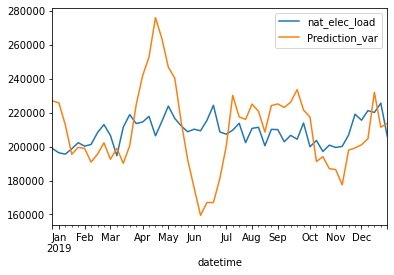

In [60]:
# Visualisation of the transformed real and predicted data
pd.concat([test, results['Prediction_var']], axis = 1).plot()

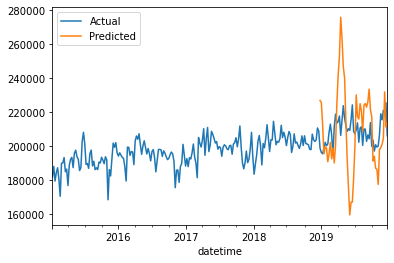

In [61]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['Prediction_var'].plot(label = 'Predicted')
plt.legend()

In [62]:
acc_var = fc_accuracy(results['Prediction_var'], data2019)
acc_var

{'mape': 0.09043813359859064,
 'me': 1081.5545654994105,
 'mae': 18991.23224130649,
 'mpe': 0.0058928227854732965,
 'rmse': 23763.657965510814}

## VAR model using less lag (n = 10)

In [63]:
# Fiting the model using 14 lags
var_results_10lags = var_model.fit(10)
var_results_10lags.summary()
lag_order_10lags = var_results_10lags.k_ar

In [64]:
# Making prediction for 2019
future_forecast_var10lags = var_results_10lags.forecast(data_multi.values[-lag_order:], 53)
future_forecast_var10lags = pd.DataFrame(future_forecast_var10lags)
future_forecast_var10lags.columns = ['nat_elec_load', 't_toc', 'h_toc', 'p_toc', 'ws_toc', 't_san', 'h_san', 'p_san',
                                     'ws_san', 't_dav', 'h_dav', 'p_dav', 'ws_dav', 'holiday_ID', 'holiday', 'school']
prediction_var10lags = future_forecast_var10lags['nat_elec_load']

In [65]:
prediction_var10lags = pd.concat([date, prediction_var10lags], axis = 1)
prediction_var10lags.datetime = pd.to_datetime(prediction_var10lags.datetime)
prediction_var10lags = prediction_var10lags.set_index("datetime")
prediction_var10lags.columns = ['Prediction_var10lags']

results['Prediction_var10lags'] = prediction_var10lags['Prediction_var10lags']

<AxesSubplot:xlabel='datetime'>

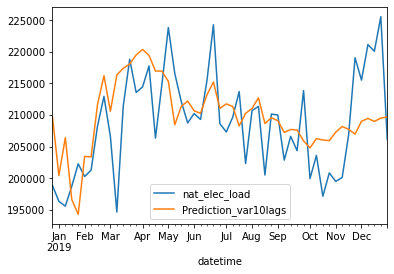

In [66]:
# Visualisation of the transformed real and predicted data
pd.concat([test, results['Prediction_var10lags']], axis = 1).plot()

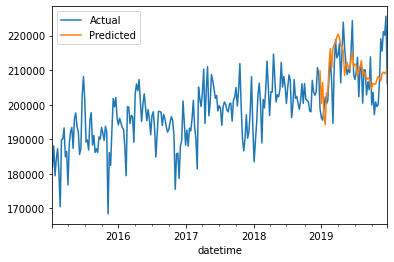

In [67]:
# Comparison of the real and modelized data in context
data_uni_w['nat_elec_load'].plot(label = 'Actual')
results['Prediction_var10lags'].plot(label = 'Predicted')
plt.legend()

In [68]:
acc_var10lags = fc_accuracy(results['Prediction_var10lags'], data2019)
acc_var10lags

{'mape': 0.026268183586807155,
 'me': 1238.7770834351843,
 'mae': 5469.680625756858,
 'mpe': 0.006865984927753518,
 'rmse': 6985.408256757254}

## Model review

In [69]:
# Combining all the accuracy results in a single data frame
acc_results = pd.DataFrame()
acc_results['metrics'] = ['mape', 'me', 'mae', 'mpe', 'rmse']
acc_results = acc_results.set_index('metrics')
acc_results['acc_manual'] = acc_manual.values()
acc_results['acc_uni'] = acc_uni.values()
acc_results['acc_multi_exo'] = acc_multi_exo.values()
acc_results['acc_multi_si'] = acc_multi_si.values()
acc_results['acc_var'] = acc_var.values()
acc_results['acc_var10lags'] = acc_var10lags.values()
acc_results

,acc_manual,acc_uni,acc_multi_exo,acc_multi_si,acc_var,acc_var10lags
metrics,,,,,,
mape,0.027740,0.040791,0.027834,0.027834,0.090438,0.026268
me,-1163.242321,7154.478479,-1503.946224,-1503.946224,1081.554565,1238.777083
mae,5830.724554,8369.995478,5857.722510,5857.722510,18991.232241,5469.680626
mpe,-0.004615,0.035293,-0.006249,-0.006249,0.005893,0.006866
rmse,7305.935325,10014.424987,7379.808099,7379.808099,23763.657966,6985.408257


<AxesSubplot:xlabel='metrics'>

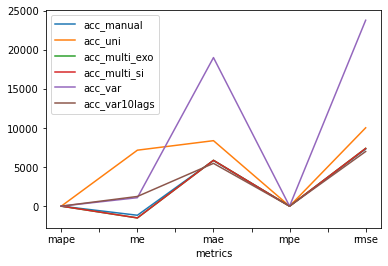

In [70]:
acc_results.plot()

In [71]:
print('aic_uni:', aic_uni)
print('aic_multi_exo:', aic_multi_exo)
print('aic_multi_si:', aic_multi_si)

aic_uni: 3218.582881215462
aic_multi_exo: 3198.9667241892353
aic_multi_si: 3198.9667241892353


<AxesSubplot:xlabel='datetime'>

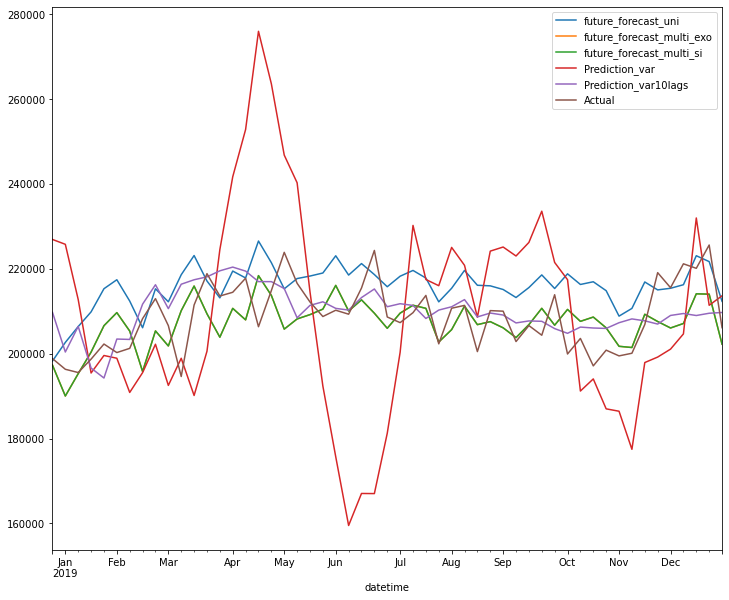

In [72]:
# Visualization of all the predictions
results['Actual'] = data2019
results.plot(figsize=(12,10))

 ### Conclusions
- Both multivariable ARIMA models give exactly the same metrics and results. This could be linked to a very negligeable impact of the exogenous variables considered on target modeling, or this might also indicates a misapplication of the models.
- There is no pattern in the residual values when using both univariate and multivariate ARIMA, with a manual application or using auto-arima.
- The KDE is mostly symmetrical in all ARIMA models, but with some anomalies at the extremities.
- The BIC is a little lower for multivariable ARIMA models (3208.058) than for the univariable ARIMA (3235.946 for manual implementation and 3227.694 for auto-arima).
- The VAR model with the prescribed number of lags (n = 14) predict very noisy and not meaningful data, and seems very prone to overfitting. 
- The VAR using less lags (n = 10) give the best results, but is a little less accurate for the last part of the modeling. This may indicates that a prediction on a one year period could be to long.
- The univariate ARIMA tend to overestimate the actual values, while the multivariate ARIMA estimation is more similar to the actual values.
- The VAR model using 14 lag seems to overestimate the cyclicity.
- In this context, the VAR using 10 lags is the best model.